In [1]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std

In [2]:
SAMPLES = 256

# Experiment 1: fast and exact filters on a particular noise model

In [3]:
# setup the FOGI model
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
target_model = mdl_datagen.copy()

In [4]:
mdl_datagen.fogi_errorgen_component_labels()

('H(X:0)_[]',
 'H(Y:0)_[]',
 'H(Z:0)_[]',
 'S(X:0)_[]',
 'S(Y:0)_[]',
 'S(Z:0)_[]',
 'H(X:0)_Gxpi2:0',
 'S(X:0)_Gxpi2:0',
 '(0.5 S(Y:0) + 0.5 S(Z:0))_Gxpi2:0',
 'H(Y:0)_Gypi2:0',
 '(0.5 S(X:0) + 0.5 S(Z:0))_Gypi2:0',
 'S(Y:0)_Gypi2:0',
 'ga(-H(Z:0))_Gypi2:0 - ga(-H(Z:0))_Gxpi2:0',
 'ga(H(Y:0))_rho0 - ga(H(Y:0))_Gxpi2:0',
 'ga(-H(Y:0))_Mdefault - ga(-H(Y:0))_Gxpi2:0',
 'ga(H(X:0))_rho0 - ga(H(X:0))_Gypi2:0',
 'ga(-H(X:0))_Mdefault - ga(-H(X:0))_Gypi2:0',
 'ga(-0.5 S(X:0) - 0.5 S(Y:0))_Mdefault - ga(-0.5 S(X:0) - 0.5 S(Y:0))_rho0')

In [5]:
hamiltonian_params = [0, 1, 2, 6, 9]
print([mdl_datagen.fogi_errorgen_component_labels()[i] for i in hamiltonian_params])

['H(X:0)_[]', 'H(Y:0)_[]', 'H(Z:0)_[]', 'H(X:0)_Gxpi2:0', 'H(Y:0)_Gypi2:0']


In [6]:
# add noise to the stochastic and hamiltonian parts of the FOGI rates
SEED = 3122
np.random.seed(SEED)

max_stochastic_error_rate = 0.001
hamiltonian_error_var = 0.05
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)


# add hamiltonian noise
ar[0:3] = np.random.normal(0, hamiltonian_error_var, 3)
ar[9] = np.random.normal(0, hamiltonian_error_var)
ar[6] = np.random.normal(0, hamiltonian_error_var)
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
print('hamiltonian-only MSE with target', mserror(mdl_datagen, target_model))
print('hamiltonian-only agsi with target', avg_gs_infidelity(mdl_datagen, target_model))

# add stochastic noise
ar[3:6] = max_stochastic_error_rate*np.random.rand(3)
ar[7:9] = max_stochastic_error_rate*np.random.rand(2)
ar[10:12] = max_stochastic_error_rate*np.random.rand(2)
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

print('MSE with target', mserror(mdl_datagen, target_model))
print('agi with target', avg_gs_infidelity(mdl_datagen, target_model))

hamiltonian-only MSE with target 0.013944923672360084
hamiltonian-only agsi with target 0.0027790049441690943
MSE with target 0.013947191474393652
agi with target 0.0034387883628381744


In [7]:
print('model is cptp', model_is_cptp(mdl_datagen))

model is cptp True


In [8]:
# make an edesign and simulate the data
maxLengths = [1,2,4,8,16]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [9]:
# load the model jacobians and hessians and calculate target model predictions
jdict = load_dict('smq1Q_XYI_jacs')
hdict = load_dict('smq1Q_XYI_hess')

In [10]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


In [11]:
print('initial MLE model is cptp', model_is_cptp(mle_estimates[0]))
print('mse with datagen', mserror(mdl_datagen, mle_estimates[0]))
print('agsi with datagen', avg_gs_infidelity(mdl_datagen, mle_estimates[0]))

initial MLE model is cptp False
mse with datagen 0.0006075813425469713
agsi with datagen -0.0019182865726703024


In [12]:
print('final MLE model is cptp', model_is_cptp(mle_estimates[-1]))
print('mse with datagen', mserror(mdl_datagen, mle_estimates[-1]))
print('agsi with datagen', avg_gs_infidelity(mdl_datagen, mle_estimates[-1]))

final MLE model is cptp False
mse with datagen 2.0799742050558297e-05
agsi with datagen -0.0001407055508451327


In [13]:
# filter the dataset using an exact filter seeded at the target and mle1 estimate
prior_covar_strength =  mserror(mdl_datagen, target_model)**2
prior_covar = prior_covar_strength*np.eye(target_model.num_params)

ekf1 = ExtendedKalmanFilter(target_model, prior_covar)
ekf2 = ExtendedKalmanFilter(mle_estimates[0], prior_covar)

ekf1.filter_dataset(edesign.circuit_lists[-1], dataset)
ekf2.filter_dataset(edesign.circuit_lists[-1], dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:38<00:00, 16.03it/s]


In [14]:
# filter the dataset using a fast filter seeded at the target
prior_covar_strength =  mserror(mdl_datagen, target_model)**2
prior_covar = prior_covar_strength*np.eye(target_model.num_params)

fkf1 = ExtendedKalmanFilter(target_model, prior_covar)

fkf1.fast_filter_dataset(edesign.circuit_lists[-1], dataset, jdict, hdict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 151.30it/s]


In [15]:
"""construct a seeded fast filter"""
initial_circuit_index = 285
prior_model = target_model.copy()
prior_model.from_vector(ekf1.param_history[initial_circuit_index])

jacs_lin = dict()
hess_lin = dict()

for circ in tqdm(edesign.circuit_lists[-1][initial_circuit_index::]):
    jacs_lin[circ] = matrix_from_jacob(prior_model.sim.dprobs(circ), 2**circ.width)
    hess_lin[circ] = tensor_from_hessian(prior_model.sim.hprobs(circ), 2**circ.width)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [03:54<00:00,  1.41it/s]


In [16]:
"""estimate with the seeded fast filter"""
fkf2 = ExtendedKalmanFilter(prior_model, ekf1.covar_history[initial_circuit_index])
fkf2.fast_filter_dataset(edesign.circuit_lists[-1][initial_circuit_index::], dataset, jacs_lin, hess_lin)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 331/331 [00:02<00:00, 132.62it/s]


In [17]:
"""set germ circuit ranges for the mle batches"""
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616],
}

Text(0, 0.5, 'MSE [log]')

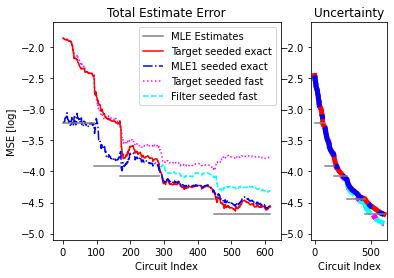

In [18]:
"""Evolution of MSE and uncertainty"""
fig, axs = plt.subplots(1, 2,  gridspec_kw={'width_ratios': [3, 1]})
y_range = [-5.1, -1.6]

axs[0].set_title('Total Estimate Error')
axs[1].set_title('Uncertainty')

true_params = mdl_datagen.to_vector()
ekf1_error = []
ekf2_error = []
fkf1_error = []
fkf2_error = []

ekf1_uncert = []
ekf2_uncert = []
fkf1_uncert = []
fkf2_uncert = []

for i in range(len(ekf1.param_history)):
    ekf1_error.append( np.log10((ekf1.param_history[i]-true_params)@(ekf1.param_history[i]-true_params)) )
    ekf2_error.append( np.log10((ekf2.param_history[i]-true_params)@(ekf2.param_history[i]-true_params)) )
    fkf1_error.append( np.log10((fkf1.param_history[i]-true_params)@(fkf1.param_history[i]-true_params)) )
    ekf1_uncert.append( np.log10((np.trace(ekf1.covar_history[i]))) )
    ekf2_uncert.append( np.log10((np.trace(ekf2.covar_history[i]))) )
    fkf1_uncert.append( np.log10((np.trace(fkf1.covar_history[i]))) )
for i in range(len(fkf2.param_history)):
    fkf2_error.append( np.log10((fkf2.param_history[i]-true_params)@(fkf2.param_history[i]-true_params)) )
    fkf2_uncert.append( np.log10((np.trace(fkf2.covar_history[i]))) )
    
fkf1_uline, = axs[1].plot(fkf1_uncert, c='magenta', lw=5, linestyle='dotted')
fkf2_uline, = axs[1].plot(range(initial_circuit_index, len(ekf1.param_history)), fkf2_uncert, c='cyan', lw=5, linestyle='dashed')
ekf1_uline, = axs[1].plot(ekf1_uncert, c='red', lw=5, linestyle='solid')
ekf2_uline, = axs[1].plot(ekf2_uncert, c='blue', lw=5, linestyle='dashdot')

fkf1_line, = axs[0].plot(fkf1_error, c='magenta', linestyle='dotted')
fkf2_line, = axs[0].plot(range(initial_circuit_index, len(ekf1.param_history)), fkf2_error, c='cyan', linestyle='dashed')
ekf1_line, = axs[0].plot(ekf1_error, c='red', linestyle='solid')
ekf2_line, = axs[0].plot(ekf2_error, c='blue', linestyle='dashdot')




if mle_estimates is not None:
    for i, mdl in enumerate(mle_estimates):
        mle_error = np.log10(mserror(mdl, mdl_datagen))
        mle_line, = axs[0].plot(germ_length_ranges[i], (mle_error, mle_error), c='gray', label='MLE Estimate')
        mle_line, = axs[1].plot(germ_length_ranges[i], (mle_error, mle_error), c='gray', label='MLE Estimate')

axs[0].legend([mle_line, ekf1_line, ekf2_line, fkf1_line, fkf2_line], ['MLE Estimates', 'Target seeded exact', 'MLE1 seeded exact', 'Target seeded fast', 'Filter seeded fast'])
if y_range is not None:
    axs[0].set_ylim(y_range[0], y_range[1])
    axs[1].set_ylim(y_range[0], y_range[1])
axs[0].set_xlabel('Circuit Index')
axs[1].set_xlabel('Circuit Index')
axs[0].set_ylabel('MSE [log]')

In [19]:
fig.savefig('MSE_evolution.eps', dpi=350, format="eps", pad_inches=0.1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [20]:
%matplotlib inline

Text(0, 0.5, 'Estimate error')

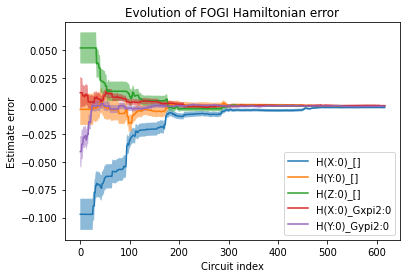

In [65]:
"""evolution of hamiltonian parameter error"""

ekf1_mserrors = np.zeros((len(hamiltonian_params), len(ekf1.param_history)))
ekf1_var = np.zeros((len(hamiltonian_params), len(ekf1.param_history)))
true_params = mdl_datagen.to_vector()

for i in range(len(ekf1.param_history)):
    for j in range(len(hamiltonian_params)):
        ekf1_mserrors[j, i] = ekf1.param_history[i][hamiltonian_params[j]]-true_params[hamiltonian_params[j]]
        ekf1_var[j, i] = ekf1.covar_history[i][hamiltonian_params[j],hamiltonian_params[j]]
param_lines = []   
for j in range(len(hamiltonian_params)):
    line, = plt.plot(ekf1_mserrors[j, :])
    sigma = np.sqrt(ekf1_var[j, :])
    param_lines.append(line)
    plt.fill_between(range(len(ekf1_mserrors[j, :])), ekf1_mserrors[j, :]-sigma, ekf1_mserrors[j, :]+sigma, alpha=0.5)
plt.legend(param_lines, [mdl_datagen.fogi_errorgen_component_labels()[i] for i in hamiltonian_params])

plt.title('Evolution of FOGI Hamiltonian error')
plt.xlabel('Circuit index')
plt.ylabel('Estimate error')

# Experiment 2: performance on random models

In [22]:
def random_fogi_model(hamiltonian_error_var, max_stochastic_error_rate):
    model_out = target_model.copy()
    ar = model_out.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
    # add hamiltonian noise
    ar[0:3] = np.random.normal(0, hamiltonian_error_var, 3)
    ar[9] = np.random.normal(0, hamiltonian_error_var)
    ar[6] = np.random.normal(0, hamiltonian_error_var)
    # add stochastic noise
    ar[3:6] = max_stochastic_error_rate*np.random.rand(3)
    ar[7:9] = max_stochastic_error_rate*np.random.rand(2)
    ar[10:12] = max_stochastic_error_rate*np.random.rand(2)
    model_out.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

    return model_out

In [56]:
hamiltonian_error_var = 0.0005
max_stochastic_error_rate= 0.0005
num_models = 50
model_list = []
itr = 0
agsis_list = []

while itr < num_models:
    ran_model = random_fogi_model(hamiltonian_error_var+0.075*(itr/num_models), max_stochastic_error_rate)
    if model_is_cptp(ran_model):
        model_list.append(ran_model)
        itr += 1
for mdl in model_list:
    agi = avg_gs_infidelity(mdl, target_model)
    agsis_list.append(agi)

In [57]:
min_agsi = min(agsis_list)
max_agsi = max(agsis_list)
print(min_agsi, max_agsi)

0.000266423078760325 0.008318409330434883


In [59]:
filters = []
fast_filters = []
final_mle_estimates = []
mserror_list = []

for mdl in model_list:
    mse = mserror(mdl, target_model)
    mserror_list.append(mse)
    ekf = ExtendedKalmanFilter(target_model, mse**2*np.eye(target_model.num_params))
    dataset = pygsti.data.simulate_data(mdl_datagen, edesign, SAMPLES)
    ekf.filter_dataset(edesign.circuit_lists[-1], dataset)
    filters.append(ekf)
    fkf = ExtendedKalmanFilter(target_model, mse**2*np.eye(target_model.num_params))
    fkf.fast_filter_dataset(edesign.circuit_lists[-1], dataset, jdict, hdict)
    fast_filters.append(fkf)
    
    mles, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)
    final_mle_estimates.append(mles[-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 177.00it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.3s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 176.19it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 176.16it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 177.13it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 3.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.4s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 171.90it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.2s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 153.38it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.7s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 167.92it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.8s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 157.08it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 162.37it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 153.98it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 155.15it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.5s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 161.74it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 3.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 156.64it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 150.64it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.9s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 153.31it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.8s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 157.91it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 3.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.8s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 161.99it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 155.05it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 4.4s


--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.6s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.1s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 167.22it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 3.6s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.0s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 152.34it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 2.5s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 3.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.4s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.42it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.5s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.10it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.8s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.7s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 155.29it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 2.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.9s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 151.55it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.8s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.4s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 152.97it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 151.61it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.7s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.1s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.23it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.4s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 155.09it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 3.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.5s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 151.85it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 3.5s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.2s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.66it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.3s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.50it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.5s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.47it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 4.7s


--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 2.7s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.7s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.2s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.66it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.4s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.34it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.5s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.95it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.0s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.86it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.8s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 153.35it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.7s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 152.87it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.7s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 153.27it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.5s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 150.31it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.7s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.8s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 155.20it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.4s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 153.22it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.8s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 142.13it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 155.07it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 2.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.8s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.0s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 157.06it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 3.4s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.1s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.81it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.3s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.3s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.91it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.5s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.9s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 152.64it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.6s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.5s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.7s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.1s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 154.25it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 5.4s


--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.4s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.8s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.6s


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [00:04<00:00, 153.82it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 2.6s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.3s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 2.7s


Text(0.5, 0, 'Filter MSE [log]')

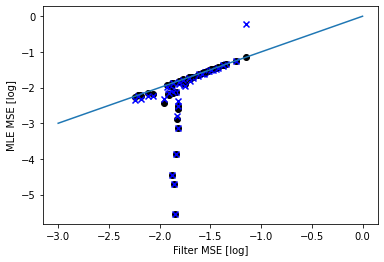

In [63]:
for i in range(len(model_list)):
    filter_mse = np.log10(mserror(filters[i].model, model_list[i]))
    mle_mse = np.log10(mserror(final_mle_estimates[i], model_list[i]))
    plt.scatter(mle_mse, filter_mse, c='black')
    fast_mse = np.log10(mserror(fast_filters[i].model, model_list[i]))
    plt.scatter(mle_mse, fast_mse, c='blue', marker='x')
plt.plot((-3, 0), (-3, 0))
plt.ylabel('MLE MSE [log]')
plt.xlabel('Filter MSE [log]')

---

In [ ]:
# find average AGSI for the given max fogi rate
avg_fidel = 0
idx = 0
max_egen_val = 0.02
while idx < 500:
    noise_model = random_copy(max_egen_val, target_model)
    if model_is_cptp(noise_model):
        avg_fidel += avg_gs_infidelity(noise_model, target_model)
        idx += 1
    else:
        print('non cptp model')
print(avg_fidel/500)

In [ ]:
# make many random FOGI models with approximately the same AGSI
target_avg_infidelity = 0.023
fidelity_epsilon = 0.001
num_noise_models = 50


noise_model_list = []
idx = 0
while idx < num_noise_models:
    noise_model = random_copy(max_egen_val, target_model)
    if model_is_cptp(noise_model):
        infidel = avg_gs_infidelity(noise_model, target_model)
        if abs(infidel - target_avg_infidelity) < fidelity_epsilon:
            noise_model_list.append(noise_model)
            idx += 1
        else:
            print(f'outlying model of fidelity {infidel}')
    else:
        print('non cptp model')

In [ ]:
# make batched MLE estimates and filter estimates for all the random models
num_samples = 256
maxLengths = [1,2,4,8]
prior_model = target_model # start at the target 
prior_covar = 0.01*np.eye(prior_model.num_params) # set the prior covar

list_of_model_lists = []
list_of_covars_lists = []
datasets = []
mle_estimates_history = []

maxlength_edesign = std.create_gst_experiment_design(maxLengths[-1])
for model in noise_model_list:
    dataset = pygsti.data.simulate_data(model, maxlength_edesign, num_samples, seed=SEED)
    datasets.append(dataset)
    mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)
    print(mserror(mle_estimates[-1], model))
    mle_estimates_history.append(mle_estimates)
    circ_list = maxlength_edesign.circuit_lists[-1]
    post_model, post_covar, saved_data = filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)
    vector_history = saved_data[0]
    covar_history = saved_data[1]
    list_of_model_lists.append(vector_history)
    list_of_covars_lists.append(covar_history)

In [ ]:
# make average performance plot over all the runs
fig, axes = plt.subplots(nrows=1, ncols=1)
fiducial_model = target_model.copy()
plt_spacing = 1

axes.set_ylim(-5, -1)

mle_mserrors = []

mse_points = {idx: [] for idx in range(num_noise_models)}

num_circs = len(list_of_model_lists[0])

for batch_idx, mle_estimate_set in enumerate(mle_estimates_history):
    for idx, estimate in enumerate(mle_estimate_set):
        mle_mserror = np.log10( mserror(estimate, noise_model_list[batch_idx]) )
        mle_mserrors.append(mle_mserror)
        mle_lines, = axes.plot(germ_length_ranges[idx], (mle_mserror, mle_mserror), alpha=0.4, c='red', lw=2)
        
for idx in range(num_noise_models):
    for id_model, model_vector in enumerate(list_of_model_lists[idx]):
        if id_model % plt_spacing == 0:
            fiducial_model.from_vector(model_vector)
            mse_points[idx].append(np.log10(mserror(fiducial_model, noise_model_list[idx])))
            #agsi_points[idx].append(np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[idx])))

for idx in range(len(mse_points)):
    filter_lines, = axes.plot(range(0, num_circs, plt_spacing), mse_points[idx], alpha=0.7, c='black')

axes.set_title('MSE between estimate and datagen')
axes.legend([filter_lines, mle_lines], ['Filter Estimate', 'Batched MLE Estimates'])

axes.set_ylabel('MSE [log]')
axes.set_xlabel('Circuit Index')

plt.show()

In [ ]:
# MSE distribution of MLE and Kalman Filter final estimates
fig, axes = plt.subplots(nrows=2, ncols=1)

filter_mserrors = []
maxlength_mle_mserrors = []
for id_model, vector_list in enumerate(list_of_model_lists):
    maxlength_mle_mserrors.append( np.log10(mserror(mle_estimates_history[id_model][-1], noise_model_list[id_model])) )
    fiducial_model.from_vector(vector_list[-1])
    filter_mserrors.append( np.log10(mserror(fiducial_model, noise_model_list[id_model])) )

axes[0].hist(filter_mserrors, color='black')
axes[0].set_title('Final Filter Estimate MSE history')
axes[1].hist(maxlength_mle_mserrors, color='black')
axes[1].set_title('Finale MLE Estimate MSE history')
axes[1].set_xlabel('MSE [log]')
axes[1].set_ylabel('Number of models')
axes[0].set_ylabel('Number of models')
axes[0].set_xlim([-4.6, -3.6])
axes[1].set_xlim([-4.6, -3.6])

In [ ]:
np.log10(avg_gs_infidelity(noise_model_list[0], target_model))

In [ ]:
# AGSI distribution of MLE and Kalman Filter final estimates
fig, axes = plt.subplots(nrows=2, ncols=1)

filter_agsis = []
for id_model, vector_list in enumerate(list_of_model_lists):
    fiducial_model.from_vector(vector_list[-1])
    filter_agsis.append( np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[id_model])) )
    
mle_agsis = []
for id_model, model_list in enumerate(mle_estimates_history):
    mle_agsis.append( np.log10(avg_gs_infidelity(model_list[-1], noise_model_list[id_model])) )

axes[0].hist(filter_agsis, color='black')
axes[0].set_title('Final Filter Estimate AGSI history')
axes[1].hist(mle_agsis, color='black')
axes[1].set_title('Finale MLE Estimate AGSI history')
axes[1].set_xlabel('AGSI [log]')
axes[1].set_ylabel('Number of models')
axes[0].set_ylabel('Number of models')
axes[0].set_xlim([-4.75, -3])
axes[1].set_xlim([-4.75, -3])

# Experiment 2

Scaling performance and performance of the fast filter

In [ ]:
# make a range of noise models with different AGSI
np.random.seed(None)
num_models_per_er = 5
max_fogi_error_rates = [0.00001*2**i for i in range(16)]
noise_model_dict = dict()
fogi_error_rate_dict = dict()
for max_er in max_fogi_error_rates:
    batch = []
    for i in range(num_models_per_er):
        ran_model = random_copy(max_er, target_model)
        while not model_is_cptp(ran_model):
            print('non cptp model')
            ran_model = random_copy(max_er, target_model)
        agsi = np.log10(avg_gs_infidelity(ran_model, target_model))
        noise_model_dict[agsi] = ran_model
        fogi_error_rate_dict[agsi] = max_er
# sort the noise models by agsi with the target
agsi_sorted = [k for k in noise_model_dict.keys()]
agsi_sorted.sort()

In [ ]:
print(max_fogi_error_rates)

In [ ]:
# make batched MLE, fast filter filter, and exact filter 
# estimates for all the random models
num_samples = 256
maxLengths = [1,2,4,8]
prior_model = target_model # start at the target 

maxlength_mle_agsi = []
exact_filter_agsis = []
fast_filter_agsis = []

maxlength_edesign = std.create_gst_experiment_design(maxLengths[-1])
for idx, agsi in enumerate(agsi_sorted):
    model = noise_model_dict[agsi]
    prior_covar = fogi_error_rate_dict[agsi]*np.eye(prior_model.num_params) 
    dataset = pygsti.data.simulate_data(model, maxlength_edesign, num_samples, seed=SEED)
    proto = pygsti.protocols.GST(target_model, gaugeopt_suite=None, verbosity=1)
    data = pygsti.protocols.ProtocolData(maxlength_edesign, dataset)
    results_after = proto.run(data)
    mle_estimate = results_after.estimates['GateSetTomography'].models['final iteration estimate']
    maxlength_mle_agsi.append( np.log10(avg_gs_infidelity(mle_estimate, model) ))
    circ_list = maxlength_edesign.circuit_lists[-1]
    fast_model, fast_covar, saved_data = fast_filter_dataset(prior_model, prior_covar, dataset, circ_list, target_preds, jdict, hdict, 
                None, None, clip_range=[-1, 1],
                max_itr=1, itr_eps=1e-4,
                save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)
    exact_model, exact_covar, saved_data = filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                None, None, clip_range=[-1, 1],
                max_itr=1, itr_eps=1e-4,
                save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)
    fast_filter_agsis.append( np.log10( avg_gs_infidelity(fast_model, model) ))
    exact_filter_agsis.append( np.log10( avg_gs_infidelity(exact_model, model) ))

In [ ]:
# plot final estimate agsi vs noise model agsi
fig, axes = plt.subplots(nrows=1, ncols=1)
fiducial_model = target_model.copy()
plt_spacing = 1

axes.scatter(agsi_sorted, fast_filter_agsis, label='Fast filter')
axes.scatter(agsi_sorted, exact_filter_agsis, label='Exact filter')
axes.scatter(agsi_sorted, maxlength_mle_agsi, label='MLE')
axes.plot((-5, 0), (-5, 0), label='y=x')

axes.legend()

axes.set_xlim([-5, 0])
axes.set_ylim([-6, 0])

axes.set_xlabel('AGSI of data generating model and target')
axes.set_ylabel('AGSI of final estimate and data generating model')
axes.set_title('Final estimate AGSI vs noise model strength')

plt.show()

In [ ]:
# plot residules with MLE model
fig, axes = plt.subplots(nrows=1, ncols=1)
fiducial_model = target_model.copy()
plt_spacing = 1

fast_residules = np.array(fast_filter_agsis) - np.array(maxlength_mle_agsi)
exact_residules = np.array(exact_filter_agsis) - np.array(maxlength_mle_agsi)

axes.scatter(agsi_sorted, fast_residules, label='Fast filter')
axes.scatter(agsi_sorted, exact_residules, label='Exact filter')

axes.legend()

axes.set_xlabel('AGSI of data generating model and target')
axes.set_ylabel('AGSI of final estimate and data generating model')

plt.show()

# Experiment 3

Posterior Fit Performance compared with CPTP model

In [86]:
cptp_target = std.target_model('CPTP')

In [87]:
# setup the datagen model
max_fogi_error_rate = 0.12
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
fogi_target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [88]:
avg_gs_infidelity(mdl_datagen, fogi_target_model)

0.11770128705202798

In [89]:
# make an edesign and simulate the data
maxLengths = [1,2,4]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(cptp_target, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, maxlength_edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [90]:
cptp_mle_estimates, edesigns = make_mle_estimates(dataset, std, cptp_target, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 3.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 6.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 7.8s


In [91]:
prior_cptp_covar = 0.1*np.eye(cptp_target.num_params)

In [93]:
post_cptp_mle1seed, cptp_mle1_covar, saved_data = filter_dataset(cptp_mle_estimates[0], prior_cptp_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:22<00:00, 12.58it/s]


In [94]:
post_cptp_targetseed, cptp_targetseed_covar, saved_data = filter_dataset(cptp_target, prior_cptp_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:25<00:00, 11.28it/s]


In [95]:
max_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset)

-847.0902220850269

In [96]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle_estimates[0])

-999.9591684826103

In [97]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle_estimates[-1])

-971.311268200813

In [98]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_zero_ekf.model)

-2404.615271471128

In [99]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle1_ekf.model)

-971.329735215731

In [100]:
fogi_mle_estimates, edesigns = make_mle_estimates(dataset, std, fogi_target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.2s


In [103]:
prior_fogi_covar = 0.1*np.eye(fogi_target_model.num_params)

In [111]:
post_fogi_mle1seed, mle1_covar, saved_data = filter_dataset(fogi_mle_estimates[0], prior_fogi_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:13<00:00, 21.09it/s]


In [105]:
post_fogi_targetseed, targetseed_covar, saved_data = filter_dataset(fogi_target_model, prior_fogi_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:13<00:00, 21.09it/s]


In [112]:
max_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset)

-847.0902220850269

In [113]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, fogi_mle_estimates[0])

-994.3977133457206

In [114]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, fogi_mle_estimates[-1])

-976.8536459996624

In [115]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, post_fogi_mle1seed)

-977.3734515824826

In [117]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, post_fogi_targetseed)

-977.0866225452755

In [ ]:
log_likelihoods = [

In [86]:
def plot_covar_evals(covar_dict):
    evals = []
    for c in range(num_circs):
        circ_eval, _ = np.linalg.eig(covar_dict[c])
        evals.append(circ_eval)
    plt.matshow(abs(np.array(evals).T))
    
def plot_covar_svals(covar_dict):
    svals = []
    for c in range(num_circs):
        _, circ_sval, _ = np.linalg.svd(covar_dict[c])
        svals.append(circ_sval)
    plt.matshow(abs(np.array(svals).T))

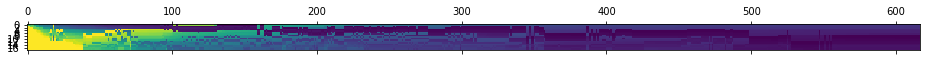

In [87]:
plot_covar_evals(mle1_covars)

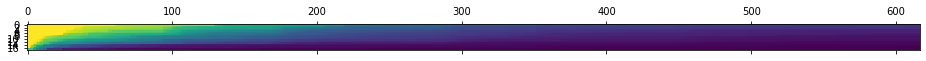

In [88]:
plot_covar_svals(mle1_covars)

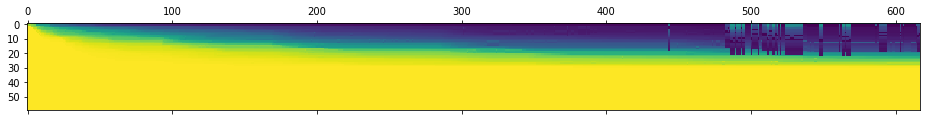

In [91]:
plot_covar_evals(cptp_mle1_covars)

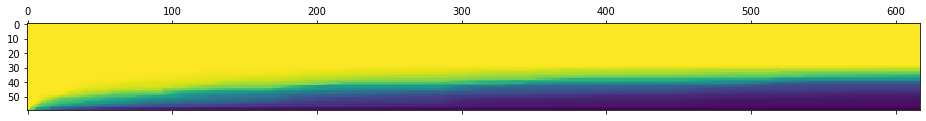

In [92]:
plot_covar_svals(cptp_mle1_covars)